In [1]:
import os
import psycopg2
from postgis.psycopg import register
import project_path
from db_importer.settings import *
from db_utils import get_rect_to_rect_data
import pandas as pd
import math
import matplotlib
import matplotlib.pyplot as plt
import numpy as np
import contextily as cx
from matplotlib import ticker


class DatabaseConnection(object):
    def __enter__(self):
        self.conn = psycopg2.connect(f"dbname='{DB_NAME}' user='{DB_USER}' password='{DB_PASSWORD}' host='{DB_HOST}' port='{DB_PORT}'")
        self.conn.autocommit = True

        register(self.conn)
        self.cur = self.conn.cursor()
 
        return self.cur

    def __exit__(self, exc_type, exc_val, exc_tb):
        if exc_tb is None:
            self.conn.commit()
            self.cur.close()
            self.conn.close()
        else:
            self.conn.rollback()
            self.cur.close()
            self.conn.close()

In [2]:
from shapely.geometry import Point
from shapely.geometry import box

start_rect = box(13.4155, 52.5213, 13.4167, 52.5219)
end_rect = box(13.4149, 52.5223, 13.4159, 52.5229)

def crop_intersection_SimRa(x):
    mask_first = x.coords.apply(lambda x: start_rect.contains(Point(x)))
    mask_end = x.coords.apply(lambda x: end_rect.contains(Point(x)))
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x.loc[first:last]
    except:
        print('check')
    
    
def crop_intersection_SUMO(x):
    mask_first = x.apply(lambda coord: start_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    mask_end = x.apply(lambda coord: end_rect.contains(Point(coord['vehicle_x'], coord['vehicle_y'])), axis = 1)
    try:
        first = mask_first[mask_first==True].index[0]
        last = mask_end[mask_end==True].index[-1]
        return x[['vehicle_x', 'vehicle_y']].loc[first:last].to_numpy()
    except:
        asasd = 12
        #print('check')
        

def plot_location(x, color, alpha, scatter):
    lon = []
    lat = []
    for c in x.coords.values:
        lon.append(c[0])
        lat.append(c[1])
    plt.plot(lon, lat, c=color, alpha=alpha, linewidth=0.7)
    if scatter:
        zero_v_coords = x.apply(lambda x: x.coords if x.velos == 0 else None,axis = 1)
        lon = []
        lat = []
        for c in zero_v_coords.values:
            if c == None:
                continue
            lon.append(c[0])
            lat.append(c[1])
        plt.scatter(lon, lat)
        
        
def to_float_arr(x):
    res = []
    for c in x:
        res.append(float(c))
    return res


In [3]:
intersections = [

    # Alexanderstr./Karl-Marx-Allee/Ottobraun-Str.
    {
        "intersection number": 1,
        "name": "Alexanderstr./Karl-Marx-Allee/Ottobraun-Str.",
        "direction": 'south to west',
        "start_rect_coords": (13.416169,52.521508,13.416513,52.521832),
        "end_rect_coords": (13.41591,52.522275,13.416421,52.522569),
        "exclude_coords": (13.415467,52.521919,13.416219,52.522107),
        "lanes in": 5,
        "lanes out": 3
    }
]
df = pd.DataFrame(intersections)
df.reindex(columns = df.columns.tolist() + ['exlude_coords','rides','fraction_cluster_1','cluster_1_is_direct_turn','no_direct_present','fraction_direct_turn']);

In [ ]:
ped_files = ['VM2_-2112701535', 'VM2_-217686115','VM2_-1247665811','VM2_-104300786', 'VM2_330973206', 'VM2_1100569031', 'VM2_421371629', 'VM2_421371629', 'VM2_1476499235', 'VM2_-1451152685', 'VM2_-1523872256']


with DatabaseConnection() as cur:
    cur.execute("""
SELECT filename,
       json_array_elements_text(st_asgeojson(geom_raw) :: json -> 'coordinates') AS coordinates,
       unnest(timestamps)                             timestamps,
       unnest(velos)                                  velos
FROM ride
where st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.4159, 52.5209), st_makepoint(13.4164, 52.5216)), 4326))
  AND st_intersects(geom, st_setsrid(
        st_makebox2d(st_makepoint(13.4157, 52.5224), st_makepoint(13.4164, 52.5227)), 4326))
  AND timestamps[1] < '2023-01-01 00:00:00'""")
    res = cur.fetchall()
    df = pd.DataFrame(res, columns=['filename', 'coords', 'timestamps', 'velos'])
    df = df[~df.coords.isnull()]
    df = df[~df['filename'].isin(ped_files)]
    df.coords = df.coords.apply(lambda x: x.replace('[', '').replace(']', '').split(','))
    df.coords = df.coords.apply(lambda x: to_float_arr(x))
    
    grouped = df.groupby('filename', as_index=False)
    df_simra = grouped.apply(lambda x: crop_intersection_SimRa(x))


In [4]:
df_simra = get_rect_to_rect_data(intersections[0]['start_rect_coords'], intersections[0]['end_rect_coords'],
        exclude_coords = intersections[0]['exclude_coords'])
df_simra_slow = df_simra.query('group == 0')
df_simra_medium = df_simra.query('group == 1')
df_simra_fast = df_simra.query('group == 2')



In [ ]:
df_default = pd.read_csv('../sim_data/alex_default.csv', delimiter=';')
df_im = pd.read_csv('../sim_data/alex_im.csv', delimiter=';')    
df_im_slow = pd.read_csv('../../im_eval/sim_data/alex_new_params_slow_new.csv', delimiter=';')
df_im_medium = pd.read_csv('../../im_eval/sim_data/alex_new_params_medium_new.csv', delimiter=';')
df_im_fast = pd.read_csv('../../im_eval/sim_data/alex_new_params_fast_new.csv', delimiter=';')
dfs=[df_im_slow, df_im_medium, df_im_fast, df_default]
df_data = []
for df in dfs:
    res = df.groupby('vehicle_id').apply(lambda x: crop_intersection_SUMO(x)).dropna()
    df_data.append(res.to_numpy())
    

In [5]:
# plotting config
columnwidth = 8
textwidth = 3.5 * 2 + 0.25
figsize = (columnwidth * 0.33, columnwidth * 0.33)
params = {
     "pdf.fonttype": 42,
     "font.family": "serif",
     "font.serif": "Linux Libertine",
     "font.sans-serif": [],
     "font.monospace": [],
     # Make the legend/label fonts a little smaller
     "font.size": 8,
     "axes.labelsize": 8,
     "axes.titlesize": 8,
     "legend.fontsize": 6,
     "legend.title_fontsize": 8,
     "xtick.labelsize": 7,
     "ytick.labelsize": 7,
     "figure.figsize": figsize,
     "figure.autolayout": True,
     # save some space around figures when saving
     "savefig.bbox": "tight",
     "savefig.pad_inches": 0.025,
}
pdf_params = {
     "text.usetex": True,
#    "pgf.texsystem": "pdflatex",
#    "pgf.rcfonts": False,
#    "pgf.preamble": "\n".join(
#        [
#            # put LaTeX preamble declarations here
#            r"\usepackage[utf8x]{inputenc}",
#            r"\usepackage[T1]{fontenc}",
#        ]
#    ),
}

findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 


FileNotFoundError: [Errno 2] No such file or directory: 'images/im_alex_default_simra_loc.png'

findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 
findfont: Generic family 'sans-serif' not found because none of the following families were found: 


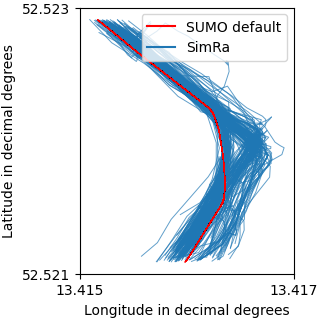

In [6]:
from matplotlib import rc

map_data = plt.figure(figsize=(columnwidth * 0.97, columnwidth * 0.97))

colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']

df_simra.groupby('filename').apply(lambda x: plot_location(x, colors[0], 0.7, False))
for ride in df_data[0]:
    plt.plot(ride[:,0], ride[:,1],c ='r', linewidth=0.5, alpha=.7)


xmin, xmax, ymin, ymax = plt.axis()
plt.xticks([xmin, xmax], [round(xmin, 3), round(xmax, 3)])
plt.xlabel('Longitude in decimal degrees')
plt.yticks([ymin, ymax], [round(ymin, 3), round(ymax, 3)])
plt.ylabel('Latitude in decimal degrees')
plt.plot([], c='r', label='SUMO default')
plt.plot([], c=colors[0], label='SimRa')
plt.legend(loc='upper right')

params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_default_simra_loc.png',dpi=1200, bbox_inches='tight')



In [ ]:
grey = matplotlib.colors.to_rgba('grey', alpha=0.7)
lightgrey = matplotlib.colors.to_rgba('grey', alpha=0.3)
blue = matplotlib.colors.to_rgba('blue', alpha=0.7)
lightblue = matplotlib.colors.to_rgba('blue', alpha=0.3)
green = matplotlib.colors.to_rgba('green', alpha=0.7)
lightgreen = matplotlib.colors.to_rgba('green', alpha=0.3)
orange = matplotlib.colors.to_rgba('darkorange', alpha=0.7)
lightorange = matplotlib.colors.to_rgba('darkorange', alpha=0.3)

In [ ]:
# map_data = plt.figure(figsize=(columnwidth * 0.97, columnwidth * 0.97))
map_data, ax = plt.subplots(figsize=figsize)
# colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
# colors = [u'#1B37B3', u'#274FFF']
# colors = ['blue', 'darkblue']
colors = [u'#001fff', u'#001085']
df_simra_slow.groupby('filename').apply(lambda x: plot_location(x, color=colors[0], alpha=1, scatter=False))
for ride in df_data[0]:
    plt.plot(ride[:,0], ride[:,1],c=colors[1], alpha=1, linewidth=0.7)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())
# ax.xaxis.set_major_locator(ticker.LinearLocator(4))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# ax.yaxis.set_major_locator(ticker.LinearLocator(4))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# plt.xticks([13.41585,13.4171], [round(13.41585, 3), round(13.4171, 3)])
# plt.xlabel('Longitude in decimal degrees')
# plt.yticks([52.5214,52.5226], [round(52.5214, 3), round(52.5226, 3)])
# plt.ylabel('Latitude in decimal degrees')
plt.plot([], c=colors[1], alpha=1, label=r'Our approach ($s$)')
plt.plot([], c=colors[0], alpha=1, label=r'SimRa ($s$)')
plt.legend(loc='upper right')
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect(1.5)
plt.xlim(13.41585,13.41706)
plt.ylim(52.5214,52.5226)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_im_simra_loc_slow.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# map_data = plt.figure(figsize=(columnwidth * 0.97, columnwidth * 0.97))
map_data, ax = plt.subplots(figsize=figsize)
# colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
colors = [u'#3BFC26',u'#1A7011']
# colors = ['lightgreen', 'darkgreen']
df_simra_medium.groupby('filename').apply(lambda x: plot_location(x, color=colors[0], alpha=1, scatter=False))
for ride in df_data[1]:
    plt.plot(ride[:,0], ride[:,1],c=colors[1], alpha=1, linewidth=0.7)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())
# ax.xaxis.set_major_locator(ticker.LinearLocator(4))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# ax.yaxis.set_major_locator(ticker.LinearLocator(4))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# plt.xticks([13.41585,13.4171], [round(13.41585, 3), round(13.4171, 3)])
# plt.xlabel('Longitude in decimal degrees')
# plt.yticks([52.5214,52.5226], [round(52.5214, 3), round(52.5226, 3)])
# plt.ylabel('Latitude in decimal degrees')
plt.plot([], c=colors[1], alpha=1, label=r'Our approach ($m$)')
plt.plot([],c=colors[0], alpha=1, label=r'SimRa ($m$)')
plt.legend(loc='upper right')
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect(1.5)
plt.xlim(13.41585,13.41706)
plt.ylim(52.5214,52.5226)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_im_simra_loc_medium.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
# map_data = plt.figure(figsize=(columnwidth * 0.97, columnwidth * 0.97))
map_data, ax = plt.subplots(figsize=figsize)
# colors = [u'#1f77b4', u'#ff7f0e', u'#2ca02c']
# colors = ['orange', 'darkorange']
colors = [u'#ff9e00', u'#965D00']
df_simra_fast.groupby('filename').apply(lambda x: plot_location(x, color=colors[0], alpha=1, scatter=False))
for ride in df_data[2]:
    plt.plot(ride[:,0], ride[:,1],c =colors[1], alpha=1, linewidth=0.7)
ax.xaxis.set_major_locator(ticker.NullLocator())
ax.xaxis.set_major_formatter(ticker.NullFormatter())
ax.yaxis.set_major_locator(ticker.NullLocator())
ax.yaxis.set_major_formatter(ticker.NullFormatter())
# ax.xaxis.set_major_locator(ticker.LinearLocator(4))
# ax.xaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# ax.yaxis.set_major_locator(ticker.LinearLocator(4))
# ax.yaxis.set_major_formatter(ticker.ScalarFormatter(useOffset=False))
# plt.xticks([13.41585,13.4171], [round(13.41585, 3), round(13.4171, 3)])
# plt.xlabel('Longitude in decimal degrees')
# plt.yticks([52.5214,52.5226], [round(52.5214, 3), round(52.5226, 3)])
# plt.ylabel('Latitude in decimal degrees')
plt.plot([], c=colors[1], label=r'Our approach ($f$)')
plt.plot([], c=colors[0], label=r'SimRa ($f$)')
plt.legend(loc='upper right')
cx.add_basemap(ax, crs='EPSG:4326', source=cx.providers.OpenStreetMap.Mapnik)
ax.set_aspect(1.5)
plt.xlim(13.41585,13.41706)
plt.ylim(52.5214,52.5226)
params.update(**pdf_params)
plt.rcParams.update(params)
plt.savefig('images/im_alex_im_simra_loc_fast.pdf',dpi=300, bbox_inches='tight')
plt.show()

In [ ]:
## Damit der läuft, muss die Legend aus den Plots ausgespart werden. Bug seitens mplleaflet.
import mplleaflet
mplleaflet.display(fig=map_data)
# mplleaflet.show(fig=map_data)